In [1]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf 
import tensorflow_addons as tfa
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Input
from  tensorflow.keras import backend as K
from numpy import random
tf.compat.v1.disable_eager_execution()

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.ERROR)

plt.rcParams['axes.facecolor'] = '#232530'
plt.rcParams['figure.facecolor'] = '#232530'
tf.disable_eager_execution()

In [2]:


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array(X)/255
y = np.array(y)
y = np.eye(10)[np.array(y,dtype=np.int16)]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
batch_size = 512
num_classes = 10
epochs = 50
M = 10
img_rows, img_cols = 28, 28

In [11]:

class LeNet:
    def __init__(self,num_classes,sigma=0.2,mu=0):
        self.num_classes = num_classes
        self.sigma = sigma
        self.mu = mu

        self.size = 28
        self.layers_shapes = [(self.size*self.size,num_classes)]
        self.layers_sizes_w = [np.prod(shape) for shape in self.layers_shapes]
        self.layers_sizes_b = [num_classes]
        
        self.initializers = None
        self.weights = None
        self.weights_size = sum(self.layers_sizes_w)
        self.biases_size = sum(self.layers_sizes_b)
        self.common_size = self.weights_size+self.biases_size
    
    def forward(self,x, weights=None):
        if(weights != None):
            weights = tf.squeeze(weights)
            assert weights.shape[0] == self.common_size
            self.weights = weights
            weights,biases = self.unflat_weights(weights)
        elif self.weights == None:
            weights = tf.truncated_normal(shape=[self.weights_size],
                                          mean = self.mu, stddev = self.sigma)
            biases = tf.zeros(shape=[self.biases_size])
    
            self.weights = tf.Variable(tf.concat([weights,biases],axis=0))
            weights, biases = self.unflat_weights(self.weights)
            self.initializers = [self.weights.initializer]

        
        flatten = tf.reshape(x,[-1,self.size*self.size])

        out = tf.add(tf.matmul(flatten, weights[0]), biases[0])
        self.out = out
        return out

    
    def flat_weights(self,weights,biases):
        weights = weights+biases
        flatten = None
        for weight in weights:
            weight = tf.reshape(weight,[-1])
            flatten = tf.concat([flatten,weight],axis=0) if flatten != None else weight
        return flatten
            
    def unflat_weights(self,weights):
            layers_shapes = self.layers_shapes
            layers_sizes_w = self.layers_sizes_w
            layers_sizes_b = self.layers_sizes_b
            
            
            biases = weights[self.weights_size:]
            weights=weights[:self.weights_size]
            unflatten_weights = []
            unflatten_biases = []
            
            for i in np.arange(len(layers_sizes_w)):
                from_ = sum(layers_sizes_w[:i])
                to_ = sum(layers_sizes_w[:i+1])
                unflatten_weights.append(tf.reshape(weights[from_:to_],layers_shapes[i]))
                
            for i in np.arange(len(layers_sizes_b)):
                from_ = sum(layers_sizes_b[:i])
                to_ = sum(layers_sizes_b[:i+1])
                unflatten_biases.append(biases[from_:to_])
                
            return unflatten_weights,unflatten_biases
            
        
    def get_weights(self):
        return self.weights
        
    def __call__(X):
        return self.out(X)

In [12]:
class Distillator:
    def __init__(self,models,
                 shape,num_classes,M,
                 batch_size,num_epochs,distillEpoches,
                 sigma=0.1,mu=0):
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.models = models
        self.num_classes = num_classes
        self.distillEpoches = distillEpoches
        
        self.learningRateX = tf.constant(1e-2,dtype=tf.float32)
        self.learningRateW = tf.Variable(1e-1,dtype=tf.float32)

        self.x_real = tf.placeholder(tf.float32, shape=[None, *shape])
        self.y_real = tf.placeholder(tf.float32, shape=[None, num_classes])

        self.x_distilled = tf.Variable(tf.truncated_normal([M, *shape] ,stddev=sigma,mean=mu))
        self.y_distilled = np.eye(num_classes)[np.arange(0,num_classes)]
        self.y_distilled = tf.Variable(self.y_distilled)
        self.statistics = {"loss":[]}
    
    def forward(self,model):
            model.forward(self.x_distilled)
            weights = model.get_weights()
            (new_weights_list,gradients_list) = [weights],[]

            for epoch in np.arange(0,self.distillEpoches):
                output = model.forward(self.x_distilled,weights=weights)
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output,
                                                                                 labels=self.y_distilled))
                dloss_dw = tf.gradients(loss,weights)
                dloss_dw = tf.squeeze(dloss_dw)
                new_weights = weights - self.learningRateW*dloss_dw
                    
                new_weights_list.append(new_weights)
                gradients_list.append(-self.learningRateW*dloss_dw)
                weights = new_weights
                
            self.__weights_initializers += model.initializers
            output = model.forward(self.x_real,weights=weights)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output,
                                                                             labels=self.y_real))
            return(loss,
                   new_weights_list,
                   gradients_list)
        
        
        
    def backward(self,forwardOutput):
        (loss,new_weights_list,
                gradients_list)  =  forwardOutput
        
        dloss_dw_last, = tf.gradients(loss,new_weights_list[-1])
        x_distilled_grad = tf.zeros_like(self.x_distilled)
        lr_grad = 0
        
        for weights,dloss_dw in reversed(list(zip(new_weights_list,gradients_list))):
            gradients = tf.gradients(dloss_dw,
                                   [self.x_distilled,
                                    self.learningRateW,
                                    weights],
                                    grad_ys=dloss_dw_last)
            (dloss_dx,dloss_dlr,ddloss_ddw) = gradients
            
            x_distilled_grad += dloss_dx
            lr_grad += dloss_dlr
            
            dloss_dw_last = dloss_dw_last+ddloss_ddw
        return x_distilled_grad,lr_grad
            
            
    def optimizer(self,gradients):
        x_grad_sum = tf.zeros_like(self.x_distilled)
        lr_grad_sum = 0
        for x_grad,lr_grad in gradients:
            x_grad_sum = x_grad_sum+x_grad
            lr_grad_sum= lr_grad_sum+lr_grad
        x_grad = x_grad_sum/len(self.models)
        lr_grad = lr_grad_sum/len(self.models)
        
        self.x_grad = x_grad
        self.lr_grad = lr_grad
        self.optimize_x = tf.assign_sub(self.x_distilled,self.learningRateX*x_grad)
        self.optimize_lr = tf.assign_sub(self.learningRateW,self.learningRateX*lr_grad)
            
        
        
        
    def train(self,X,y):
        sess = tf.Session()
        self.sess = sess
        sess.run([self.x_distilled.initializer,
                  self.y_distilled.initializer,
                  self.learningRateW.initializer])
        
        self.__weights_initializers = []
        
        gradients = []
        lossSum = 0
        
        for model in self.models:
            forwardOutput = self.forward(model)
            loss,_,_  = forwardOutput
            lossSum = lossSum+loss
            gradients.append(self.backward(forwardOutput))
        self.optimizer(gradients)
        
        for epoch in np.arange(0,self.num_epochs):
            for step_i in np.arange(0,X.shape[0], self.batch_size):
                x_real_batch = X[step_i:step_i + self.batch_size,:]
                y_real_batch = y[step_i:step_i + self.batch_size,:]
                
                sess.run(self.__weights_initializers)
                
                sess.run([self.optimize_x,self.optimize_lr],
                        feed_dict={self.x_real:x_real_batch,
                                                    self.y_real:y_real_batch})

            self.statistics["loss"].append(
            sess.run(lossSum,
                     feed_dict={self.x_real:x_real_batch,
                                                    self.y_real:y_real_batch}))
                                
                
                
                
    def getDistilledData(self):
        return self.sess.run([self.x_distilled,self.y_distilled])

In [13]:
tf.reset_default_graph()
distillator = Distillator([LeNet(10)],[img_rows,img_cols,1],num_classes,M,
                          batch_size,num_epochs=epochs,distillEpoches=3)
distillator.train(X_train.reshape(X_train.shape[0],img_rows,img_rows,1),
                  y_train)

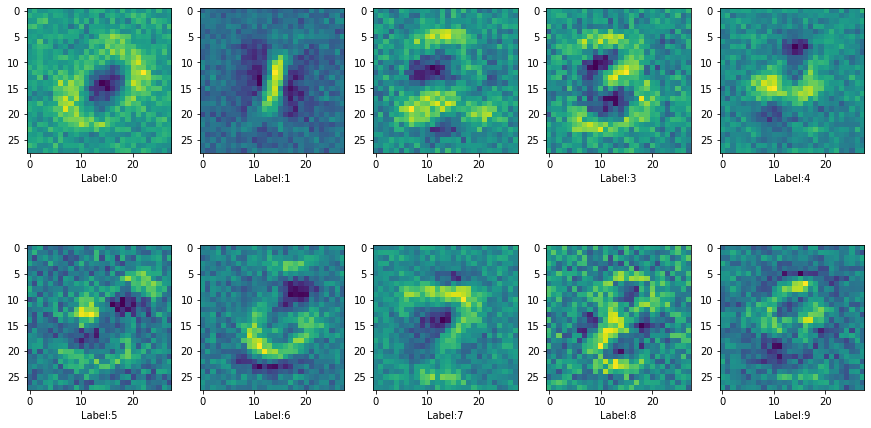

In [14]:
x__,y__ = distillator.getDistilledData()

gridsize = (2, 5)
fig = plt.figure(figsize=(15, 8))
for i in range(10):
    ax = plt.subplot2grid(gridsize, (i//5, i%5))
    ax.imshow(x__.reshape(10,28,28)[i])
    plt.xlabel("Label:{0}".format(i))
# plt.savefig('figs.jpg')

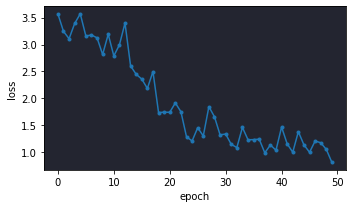

In [15]:
x = np.array(np.arange(len(distillator.statistics["loss"]),dtype=int))
y = distillator.statistics["loss"]

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x,y,marker=".")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.tight_layout()